In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pymsm.multi_state_competing_risks_model import PathObject, MultiStateModel
from pymsm.datasets import prep_ebmt_long
from pymsm.plotting import stackplot_state_timesteps, stackplot_state_timesteps_from_paths
from pymsm.statistics import (
    prob_visited_states,
    stats_total_time_at_states,
    paths_to_timestep_matrix,
    get_state_timestep_probs
)
from pymsm.survival_tree_fitter import SurvivalTreeWrapper

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## The EBMT dataset  
Data from the European Society for Blood and Marrow Transplantation (EBMT)  
  
A data frame of 2279 patients transplanted at the EBMT between 1985 and 1998.  
(from R mstate package, see: https://www.rdocumentation.org/packages/mstate/versions/0.3.1/topics/EBMT%20data)  


In [7]:
from pymsm.datasets import load_ebmt, prep_ebmt_long, plot_ebmt
load_ebmt().head()

,id,from,to,trans,Tstart,Tstop,time,status,match,proph,year,agecl
1,1,1,2,1,0.0,22.0,22.0,1,no gender mismatch,no,1995-1998,20-40
2,1,1,3,2,0.0,22.0,22.0,0,no gender mismatch,no,1995-1998,20-40
3,1,1,5,3,0.0,22.0,22.0,0,no gender mismatch,no,1995-1998,20-40
4,1,1,6,4,0.0,22.0,22.0,0,no gender mismatch,no,1995-1998,20-40
5,1,2,4,5,22.0,995.0,973.0,0,no gender mismatch,no,1995-1998,20-40


In [8]:
competing_risk_dataset, covariate_cols, state_labels = prep_ebmt_long()
competing_risk_dataset.head()

,sample_id,origin_state,target_state,time_entry_to_origin,time_transition_to_target,match_no gender mismatch,proph_yes,year_1990-1994,year_1995-1998,agecl_<=20,agecl_>40
0,1,1,2,0.0,22.0,1,0,0,1,0,0
1,1,2,0,22.0,995.0,1,0,0,1,0,0
2,2,1,3,0.0,12.0,1,0,0,1,0,0
3,2,3,4,12.0,29.0,1,0,0,1,0,0
4,2,4,5,29.0,422.0,1,0,0,1,0,0


In [10]:
plot_ebmt(competing_risk_dataset, state_labels, covariate_cols, terminal_states=[5, 6])

## Multi-state model based on Survival-Trees   

In [13]:
from pymsm.survival_tree_fitter import SurvivalTreeWrapper


terminal_states = [5, 6]

multi_state_model = MultiStateModel(
    dataset=competing_risk_dataset,
    terminal_states=terminal_states,
    covariate_names=covariate_cols,
    event_specific_fitter=SurvivalTreeWrapper,
    competing_risk_data_format=True,
    state_labels=state_labels
)


multi_state_model.fit()

Fitting Model at State: 1
>>> Fitting Transition to State: 2, n events: 785
>>> Fitting Transition to State: 3, n events: 907
>>> Fitting Transition to State: 5, n events: 95
>>> Fitting Transition to State: 6, n events: 160
Fitting Model at State: 2
>>> Fitting Transition to State: 5, n events: 112
>>> Fitting Transition to State: 6, n events: 39
>>> Fitting Transition to State: 4, n events: 227
Fitting Model at State: 3
>>> Fitting Transition to State: 4, n events: 433
>>> Fitting Transition to State: 6, n events: 197
>>> Fitting Transition to State: 5, n events: 56
Fitting Model at State: 4
>>> Fitting Transition to State: 5, n events: 107
>>> Fitting Transition to State: 6, n events: 137


# Single patient statistics

In [14]:
# Run MC for a sample single patient
mc_paths = multi_state_model.run_monte_carlo_simulation(
    sample_covariates=competing_risk_dataset.loc[0, covariate_cols].values,
    origin_state=1,
    current_time=0,
    n_random_samples=1000,
    max_transitions=10,
)


100%|██████████| 1000/1000 [00:09<00:00, 109.50it/s]


In [15]:
all_states = competing_risk_dataset["target_state"].unique()
# Probability of visiting any of the states
for state in all_states:
    if state == 0:
        continue
    print(
        f"Probabilty of {state_labels[state]} = {prob_visited_states(mc_paths, states=[state])}"
    )

# Probability of terminal states - Death and Relapse
print(
    f"Probabilty of any terminal state = {prob_visited_states(mc_paths, states=multi_state_model.terminal_states)}"
)

Probabilty of Rec = 0.394
Probabilty of AE = 0.37
Probabilty of AE & Rec = 0.555
Probabilty of Relapse = 0.239
Probabilty of Death = 0.761
Probabilty of any terminal state = 1.0


In [16]:
# Stats for times at states
dfs = []
for state in all_states:
    if state == 0 or state in terminal_states:
        continue
    dfs.append(
        pd.DataFrame(
            data=stats_total_time_at_states(mc_paths, states=[state]),
            index=[state_labels[state]],
        )
    )
pd.concat(dfs)


,time_in_state_mean,time_in_state_std,time_in_state_median,time_in_state_min,time_in_state_max,time_in_state_quantile_0.1,time_in_state_quantile_0.25,time_in_state_quantile_0.75,time_in_state_quantile_0.9
Rec,5.868002,10.814552,0.000000,0.0,73.999936,0.0,0.0,8.250040,20.999915
AE,34.099998,61.212106,0.000000,0.0,316.000005,0.0,0.0,33.249942,135.099984
AE & Rec,101.463986,165.080015,42.999949,0.0,1004.999976,0.0,0.0,130.999944,288.099975


# Multiple runs stats

timestep_matrix
 [[1 2 2 3 0]
 [1 1 2 2 3]
 [1 1 5 5 5]]
state_timestep_probs



{1: array([1.        , 0.66666667, 0.        , 0.        , 0.        ]),
 2: array([0.        , 0.33333333, 0.66666667, 0.33333333, 0.        ]),
 3: array([0.        , 0.        , 0.        , 0.33333333, 0.5       ]),
 5: array([0.        , 0.        , 0.33333333, 0.33333333, 0.5       ])}

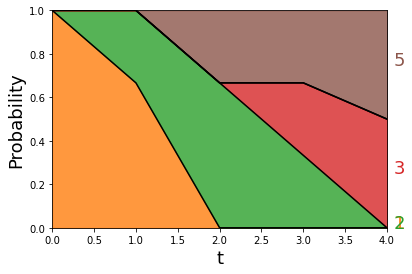

In [17]:
# Test scenario

test_paths = [
    PathObject(states=[1, 2, 3], time_at_each_state=[1, 2, 1]),
    PathObject(states=[1, 2, 3], time_at_each_state=[2, 2, 1]),
    PathObject(states=[1, 5], time_at_each_state=[2]),
]
true_timestep_matrix = np.array([[1, 2, 2, 3, 0], [1, 1, 2, 2, 3], [1, 1, 5, 5, 5]])
max_timestep = 5
timestep_matrix = paths_to_timestep_matrix(test_paths, max_timestep)
print("timestep_matrix\n", timestep_matrix)

state_timestep_probs = get_state_timestep_probs(timestep_matrix)
print("state_timestep_probs\n")


stackplot_state_timesteps(state_timestep_probs, order_top=[5], order_bottom=[1, 2, 3,])

state_timestep_probs


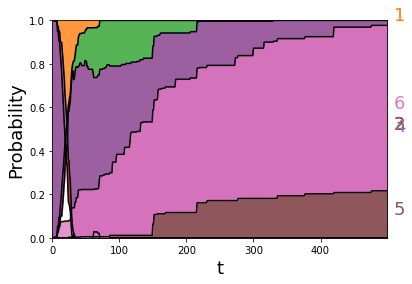

In [19]:
max_timestep = 500
stackplot_state_timesteps_from_paths(
    mc_paths, max_timestep, order_top=[1, 2, 3, 4], order_bottom=[5, 6]
)